In [1]:
# until the github pip foolbox is updated
import sys
sys.path.insert(0,'/media/rene/code/foolbox')
import foolbox

In [2]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Nicer way to import the module?
sys.path.append(str(Path.cwd().parent))

from models.cifar import resnet
from utils.display import load_image, show_img
from utils.loading import load_net_cifar

import torch
from torch import nn
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients
import torchvision.transforms as T
from torchvision.models import resnet18, vgg16
import foolbox
import json
from PIL import Image

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(torch.cuda.device_count())
print(torch.cuda.current_device())

2
0


# Check Adversarial Dataset
* Images from FGSM look resonable
* For some reason about 1% of the images didn't work and are missing

In [22]:
with open('/media/rene/data/adv_denoising/cifar10/adv_fgsm/resnet50/sample/files_df_adv.pkl', 'rb') as f:
    files_df = pickle.load(f)
    
model_loc = '/media/rene/data/adv_denoising/cifar10/cifar10_normal/models/resnet-50_model_best.pth.tar'
classifier_model = load_net_cifar(model_loc).eval()

Loading model_file resnet-50


/media/rene/data/adv_denoising/cifar10/cifar10_normal/train/train_317.png
label 2
predicted class 2
adversarial class 2


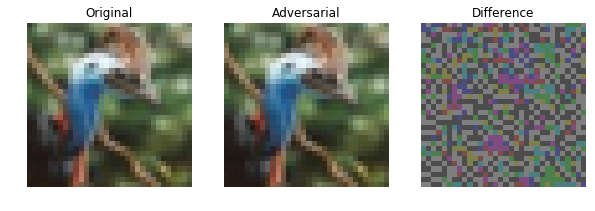

In [23]:
mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
std = np.array([0.2023, 0.1994, 0.2010]).reshape((3, 1, 1))

idx = np.random.randint(0, len(files_df['train']))

img_path = files_df['train']['path'].iloc[idx]
print(img_path)
adv_path = files_df['train']['adv_path'].iloc[idx]
label = files_df['train']['class'].iloc[idx]

image = load_image(img_path)
adversarial = load_image(adv_path)

fmodel = foolbox.models.PyTorchModel(
    classifier_model, bounds=(0, 1), num_classes=10, preprocessing=(mean, std))

print('label', label)
print('predicted class', np.argmax(fmodel.predictions(image)))
print('adversarial class', np.argmax(fmodel.predictions(adversarial)))

show_img(image, adversarial)

What if we have layers where at each location only one feature can be active. Then do some kind of beam search over this to the the overall activations, just like in NLP

# Check the Classifier

In [16]:
from models.cifar import resnet
from utils.data import make_generators_DF_cifar
from utils.train_val_denoise import train_epoch_denoise, validate_epoc_denoise, save_checkpoint
from utils.loading import load_net_cifar
from models import DenoiseNet, DenoiseHGD, DenoiseLoss, UNet   

files_df_loc = '/media/rene/data/adv_denoising/cifar10/adv_fgsm/resnet50/sample/files_df_adv.pkl'
model_loc = '/media/rene/data/adv_denoising/cifar10/cifar10_normal/models/resnet-50_model_best.pth.tar'
device = torch.device('cuda:1')
batch_size = 128
num_workers = 4

with open(files_df_loc, 'rb') as f:
    files_df = pickle.load(f)
    
dataloaders = make_generators_DF_cifar(files_df, batch_size, num_workers, size=32, 
                                       path_colname='path', adv_path_colname='adv_path', return_loc=False)

model_name = 'DenoiseHGD'
fwd_out = [64, 128, 256, 256, 256]
num_fwd = [2, 3, 3, 3, 3]
back_out = [64, 128, 256, 256]
num_back = [2, 3, 3, 3]
fwd_in = 3
denoiser = DenoiseHGD(32, 32, fwd_in, fwd_out, num_fwd, back_out, num_back).to(device)
classifier = load_net_cifar(model_loc).to(device)
loss = DenoiseLoss(n=1, hard_mining=0, norm=False)
model = DenoiseNet(classifer=classifier, denoiser=denoiser, loss=loss).to(device)

Loading model_file resnet-50


In [19]:
val_adv_acc, val_loss = validate_epoc_denoise(dataloaders['val'], model, requires_control=False, device=device)

/media/rene/ADV/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/media/rene/ADV/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Original Acc 93.266 	 Adversarial Acc  34.774 Loss (213.4918)	Time (0.125)	 Data Time (0.030)


## Stochastic pooling

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
kernel_size = (2, 2)
stride = (2, 2)

img = load_image('/media/rene/data/adv_denoising/cifar10/cifar10_normal/train/train_20769.png')
x = torch.from_numpy(img).unsqueeze(0)
init_size = x.shape
print(init_size)
x = x.unfold(2, kernel_size[0], stride[0])
print(x.shape)
x = x.unfold(3, kernel_size[1], stride[1])
print(x.shape)
x = x.contiguous().view(x.size()[:4] + (-1,))
print(x.shape)
x = x.view(-1, 4)
print(x.shape)

print('x.mean()', x.mean())
x = torch.stack([
                 x_i[torch.multinomial(x_i, num_samples=1)] for i, x_i in enumerate(torch.unbind(x, dim=0), 0)
                ], dim=0)
print('x.mean()', x.mean())
x = x.contiguous().view(init_size[0], init_size[1], int(init_size[2]/2), int(init_size[3]/2))
print(x.shape)

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 16, 32, 2])
torch.Size([1, 3, 16, 16, 2, 2])
torch.Size([1, 3, 16, 16, 4])
torch.Size([768, 4])
x.mean() tensor(0.6594)
x.mean() tensor(0.6830)
torch.Size([1, 3, 16, 16])


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

kernel_size = (2, 2)
stride = (2, 2)

x = torch.from_numpy(np.reshape(np.random.normal(10, .001, 5*64*32*32), (5, 64, 32, 32))).to(device)
init_size = x.shape
print(init_size)
x = x.unfold(2, kernel_size[0], stride[0]).unfold(3, kernel_size[1], stride[1])
print(x.shape)
x = x.contiguous().view(-1, 4)
print(x.shape)
print('x.mean()', x.mean())
x = torch.stack([
                 x_i[torch.multinomial(x_i, num_samples=1)] for i, x_i in enumerate(torch.unbind(x, dim=0), 0)
                ], dim=0)
print('x.mean()', x.mean())
x = x.contiguous().view(init_size[0], init_size[1], int(init_size[2]/2), int(init_size[3]/2))
print(x.shape)

torch.Size([5, 64, 32, 32])
torch.Size([5, 64, 16, 16, 2, 2])
torch.Size([81920, 4])
x.mean() tensor(10.0000, device='cuda:1', dtype=torch.float64)
x.mean() tensor(10.0000, device='cuda:1', dtype=torch.float64)
torch.Size([5, 64, 16, 16])


In [6]:
batch_size = 8
img1 = np.expand_dims(load_image('/media/rene/data/adv_denoising/cifar10/cifar10_normal/train/train_20769.png'),0)
img2 = np.expand_dims(load_image('/media/rene/data/adv_denoising/cifar10/cifar10_normal/train/train_317.png'),0)

img = np.concatenate((img1, img2), axis=0)
x = torch.from_numpy(img)

print(device)
kernel_size = (2, 2)
stride = (2, 2)
init_size = x.shape

with torch.cuda.device(1):
    print(x.shape)
    x = x.unfold(2, kernel_size[0], stride[0]).unfold(3, kernel_size[1], stride[1])
    print(x.shape)
    x = x.contiguous().view(-1, 4)
    print(x.shape)
    x = torch.stack([
             x_i[torch.multinomial(x_i, num_samples=1)] for i, x_i in enumerate(torch.unbind(x, dim=0), 0)
            ], dim=0)
    x = x.contiguous().view(init_size[0], init_size[1], int(init_size[2]/2), int(init_size[3]/2))
    print(x.shape)

cuda:1
torch.Size([2, 3, 32, 32])
torch.Size([2, 3, 16, 16, 2, 2])
torch.Size([1536, 4])
torch.Size([2, 3, 16, 16])


## Sample randomly if all equal

In [5]:
img1 = np.expand_dims(load_image('/media/rene/data/adv_denoising/cifar10/cifar10_normal/train/train_20769.png'),0)
img2 = np.expand_dims(load_image('/media/rene/data/adv_denoising/cifar10/cifar10_normal/train/train_317.png'),0)

img = np.concatenate((img1, img2), axis=0)
x = torch.from_numpy(img)

print(device)
kernel_size = (2, 2)
stride = (2, 2)
init_size = x.shape

with torch.cuda.device(1):
    def gen_random(values):
        if torch.sum(values) == 0:
            idx = torch.multinomial(values, num_samples=1)
        else:
            idx = int(torch.randint(0, values.shape[0], size=(1,))[0])
            
        return values[idx]
    x = x.unfold(2, kernel_size[0], stride[0]).unfold(3, kernel_size[1], stride[1])
    x = x.contiguous().view(-1, 4)
    print(x.shape)
    x = torch.stack([
             gen_random(x_i) for i, x_i in enumerate(torch.unbind(x, dim=0), 0)
            ], dim=0)
    x = x.contiguous().view(init_size[0], init_size[1], int(init_size[2]/2), int(init_size[3]/2))
    print(x.shape)

cuda:1
torch.Size([1536, 4])
torch.Size([2, 3, 16, 16])


## Too slow

In [14]:
img1 = np.expand_dims(load_image('/media/rene/data/adv_denoising/cifar10/cifar10_normal/train/train_20769.png'),0)
img2 = np.expand_dims(load_image('/media/rene/data/adv_denoising/cifar10/cifar10_normal/train/train_317.png'),0)

img = np.concatenate((img1, img2), axis=0)
x = torch.from_numpy(img)

print(device)
kernel_size = (2, 2)
stride = (2, 2)
init_size = x.shape

with torch.cuda.device(1):
    x = x.unfold(2, kernel_size[0], stride[0]).unfold(3, kernel_size[1], stride[1])
    x = x.contiguous().view(-1, 4)
    print(x.shape)
    print(x)
    idx = torch.randint(0, x.shape[1], size=(x.shape[0],)).type(torch.LongTensor)
    print(idx)
    x = torch.index_select(x, 1, idx)
    print(idx.shape)
    print(x.shape)
    print(x)

cuda:1
torch.Size([1536, 4])
tensor([[0.9961, 0.8941, 0.9725, 0.5451],
        [0.4902, 0.3961, 0.1804, 0.2980],
        [0.8078, 0.8863, 0.3059, 0.3843],
        ...,
        [0.0941, 0.1843, 0.1373, 0.1255],
        [0.2118, 0.2471, 0.1765, 0.2000],
        [0.2784, 0.2118, 0.1922, 0.1647]])
tensor([0, 1, 0,  ..., 3, 3, 0])
torch.Size([1536])
torch.Size([1536, 1536])
tensor([[0.9961, 0.8941, 0.9961,  ..., 0.5451, 0.5451, 0.9961],
        [0.4902, 0.3961, 0.4902,  ..., 0.2980, 0.2980, 0.4902],
        [0.8078, 0.8863, 0.8078,  ..., 0.3843, 0.3843, 0.8078],
        ...,
        [0.0941, 0.1843, 0.0941,  ..., 0.1255, 0.1255, 0.0941],
        [0.2118, 0.2471, 0.2118,  ..., 0.2000, 0.2000, 0.2118],
        [0.2784, 0.2118, 0.2784,  ..., 0.1647, 0.1647, 0.2784]])
